# 1. IMPORTS

In [1]:
# misc libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


# 2. Dataset generation

## Constant and functions

In [2]:
ROOT_DIR= '/mnt/d/NOTES-ARCHIVE/PROJECT3/Code/Dataset_distilled'
LABELS= ["Benign","Bruteforce","Dos/DDos","Mirai","Recon","Spoofing","Web-based"]

In [3]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return 1

## Loading and dropping column with single-value

In [5]:
df = pd.read_csv(f'{ROOT_DIR}/dataset.csv')

In [6]:
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)
df.drop(single_value_cols,axis=1, inplace=True) 

In [7]:
# Display the original class distribution
print(df['class'].value_counts(ascending=True))

class
Bruteforce     7544
Benign        10000
Dos/DDos      10000
Spoofing      10000
Mirai         10000
Recon         10000
Web-based     10000
Name: count, dtype: int64


<Axes: >

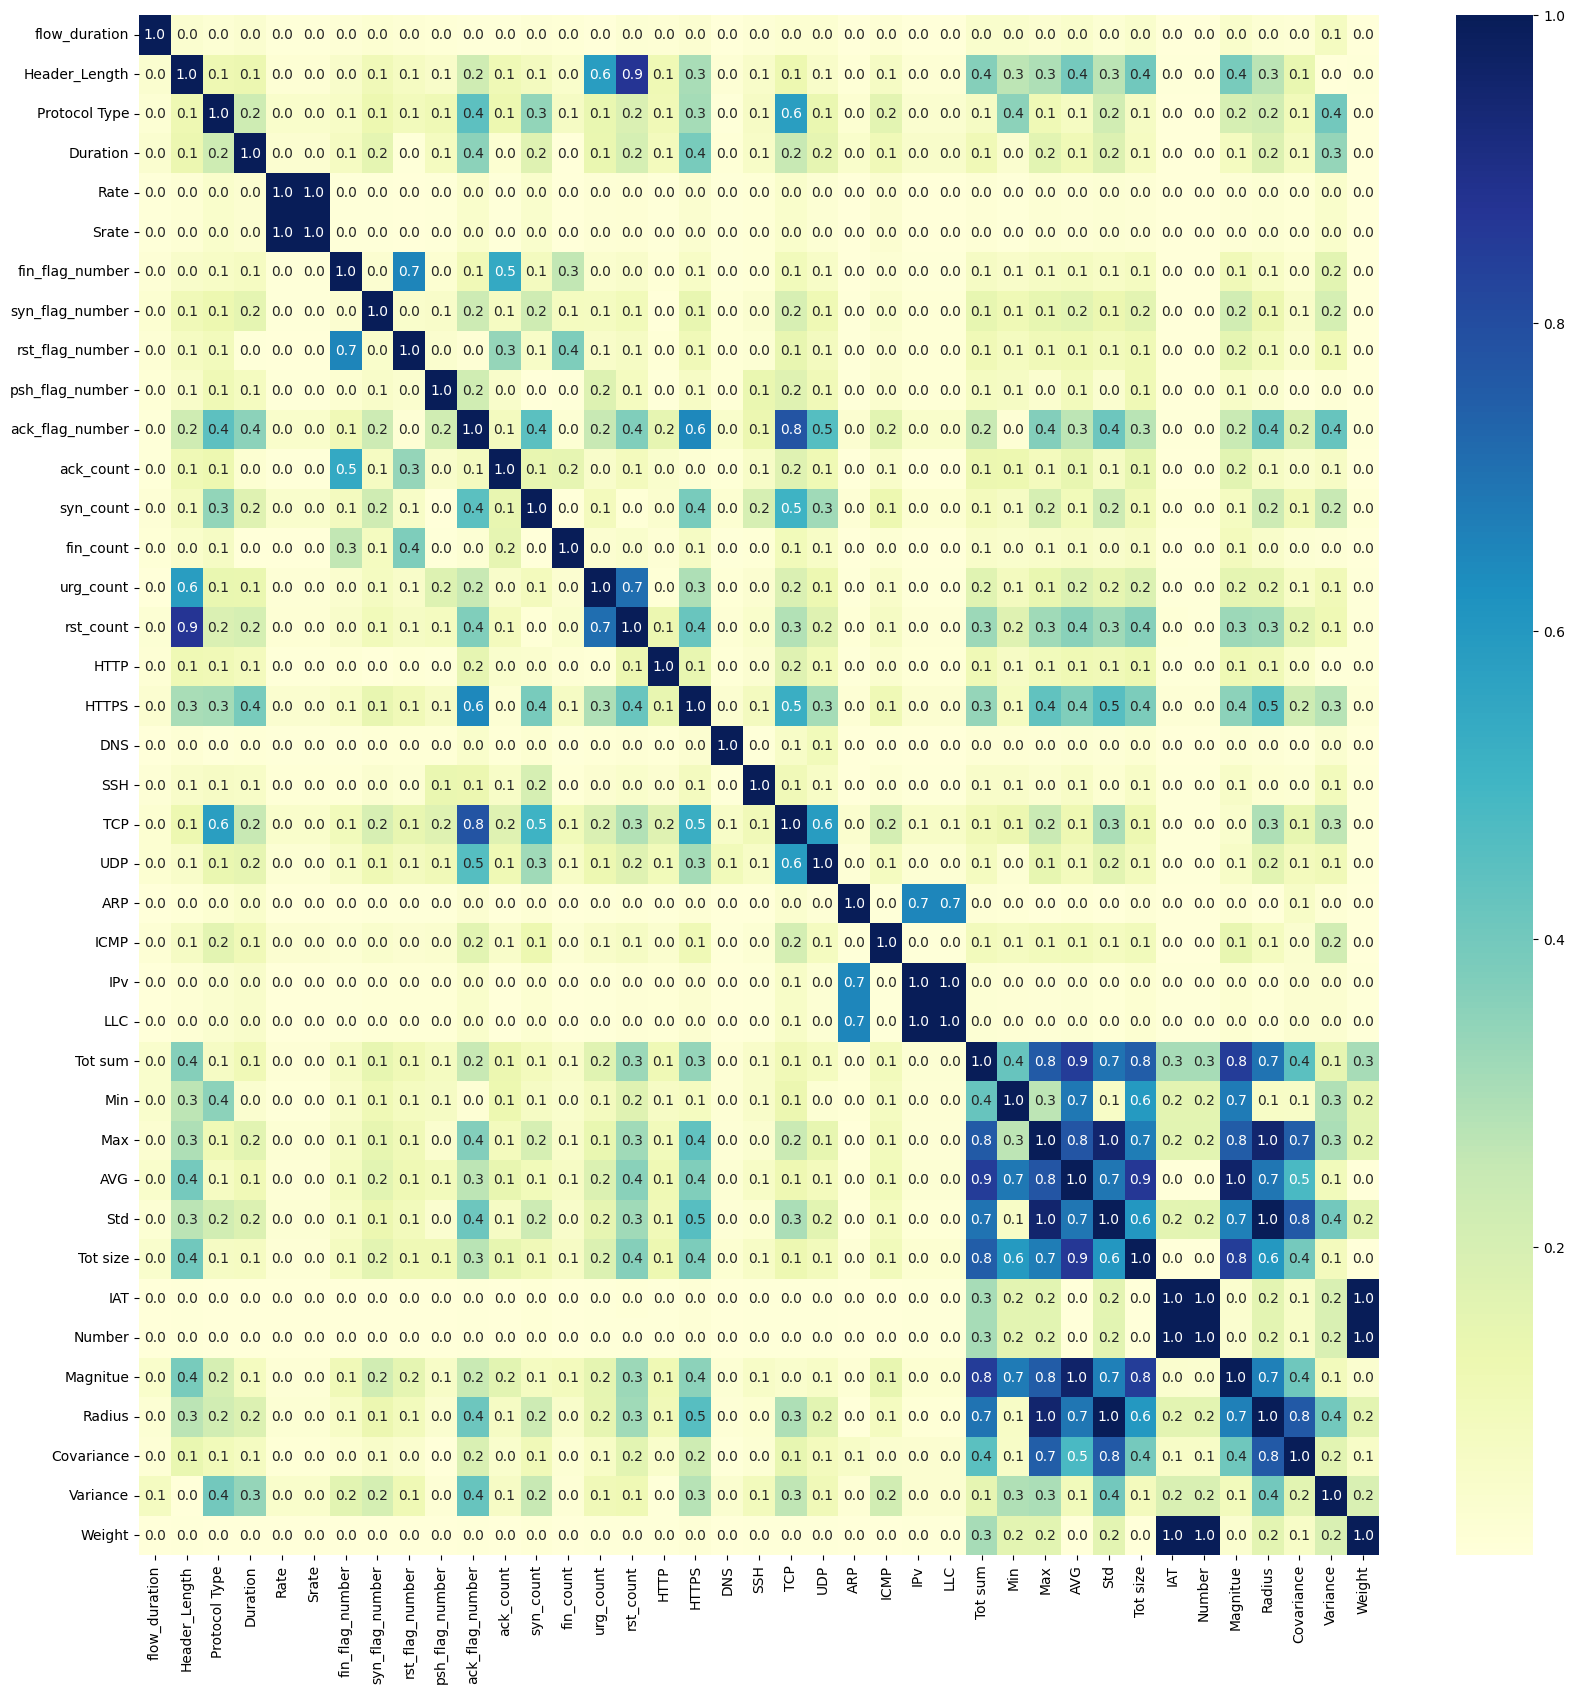

In [8]:
# Display the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")


In [9]:
# Display number of columns
num_columns = df.shape[1]

# Output the number of columns
print(f"The number of columns in the DataFrame is: {num_columns}")

The number of columns in the DataFrame is: 40


## Split into training and testing set

In [10]:
sub_df = df  

# remove nan, inf, -inf value
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)] 

In [11]:
X = sub_df.iloc[:,:-1]
Y = sub_df.iloc[:,-1]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))
print(X_train.shape,X_test.shape)

(54035, 39) (13509, 39)


## Data scaling

In [13]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Random Forest

## Grid search for best parameter

In [14]:
# rfc = RandomForestClassifier()

# # Create a dictionary of all values we want to test for n_estimators
# parameters = {'n_estimators': [1, 2, 4, 10, 15, 20, 30, 40, 50, 100, 200, 500, 1000]}

# # Used to find the best n_estimators value to use to train the model
# rfc_grid = GridSearchCV(
#   rfc,
#   parameters,
#   scoring='accuracy',
#   cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
#   n_jobs=-1 # Use all cores
# )

# # Fit model to data
# rfc_grid.fit(X_train, Y_train)

# # Extract best params
# print(f"Best params: {rfc_grid.best_params_}")
# print(f"Best score: {rfc_grid.best_score_}")

### Training
- From n_estimators > 1000, the model performance stays relatively the same

In [15]:
# RF_clf = RandomForestClassifier(n_estimators=200,max_depth=20, max_leaf_nodes=1000,n_jobs=-1)
RF_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
RF_clf.fit(X_train_scaled, Y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

## Benchmarking

              precision    recall  f1-score   support

      Benign       0.84      0.91      0.88      1975
  Bruteforce       0.86      0.81      0.84      1564
    Dos/DDos       1.00      0.99      1.00      1974
       Mirai       1.00      0.99      1.00      2001
       Recon       0.90      0.76      0.83      2017
    Spoofing       0.92      0.83      0.87      2000
   Web-based       0.77      0.95      0.85      1978

    accuracy                           0.90     13509
   macro avg       0.90      0.89      0.89     13509
weighted avg       0.90      0.90      0.90     13509



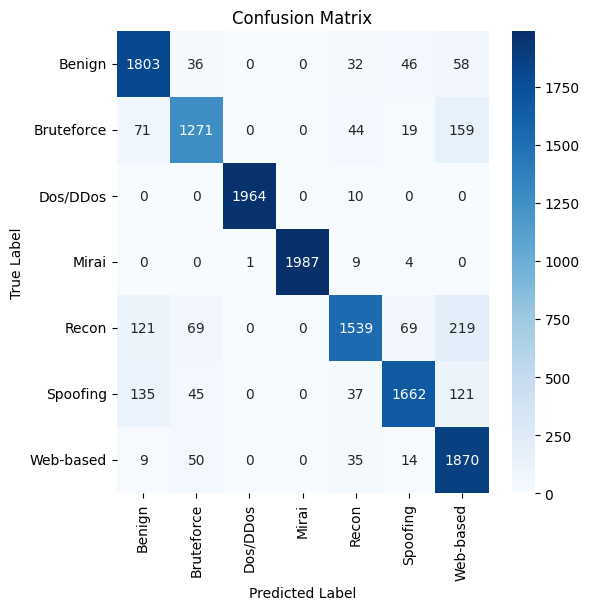

1

In [16]:
RF_clf_Y_pred = RF_clf.predict(X_test_scaled)
print(classification_report(Y_test, RF_clf_Y_pred))
plot_confusion_matrix(Y_test,RF_clf_Y_pred)
# ConfusionMatrixDisplay.from_predictions(Y_test, RF_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 4. SGDC classifier

## Grid search for best parameter

In [17]:
# param_grid = {
#     'alpha': [1e-4, 1e-3, 1e-2],
#     'loss': ['hinge', 'log', 'modified_huber'],
#     'penalty': ['l2', 'l1', 'elasticnet'],
#     'learning_rate': ['constant', 'optimal', 'adaptive'],
#     'eta0': [0.01, 0.1, 1.0],
# }

# sgd = SGDClassifier(random_state=42)
# grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train_scaled, Y)

# print("Best Parameters:", grid_search.best_params_)

### Training SGDC
- According to different scaling methods used above, the model is consistently performed at its best when paired with the PowerTransformer scaling method

In [18]:
SGDC_clf = SGDClassifier(eta0=1.0,penalty='elasticnet',learning_rate='adaptive',alpha=0.0001,max_iter=10000, tol=1e-9,n_jobs=-1)
SGDC_clf.fit(X_train_scaled,Y_train)

/home/gray/tensorflow/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/gray/tensorflow/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('sgdclassifier',
                 SGDClassifier(max_iter=10000, n_jobs=-2, tol=1e-05))])

## Benchmarking

              precision    recall  f1-score   support

      Benign       0.54      0.68      0.60      1975
  Bruteforce       0.52      0.18      0.26      1564
    Dos/DDos       0.99      0.99      0.99      1974
       Mirai       1.00      0.99      0.99      2001
       Recon       0.58      0.46      0.51      2017
    Spoofing       0.62      0.55      0.58      2000
   Web-based       0.50      0.80      0.62      1978

    accuracy                           0.68     13509
   macro avg       0.68      0.66      0.65     13509
weighted avg       0.68      0.68      0.66     13509



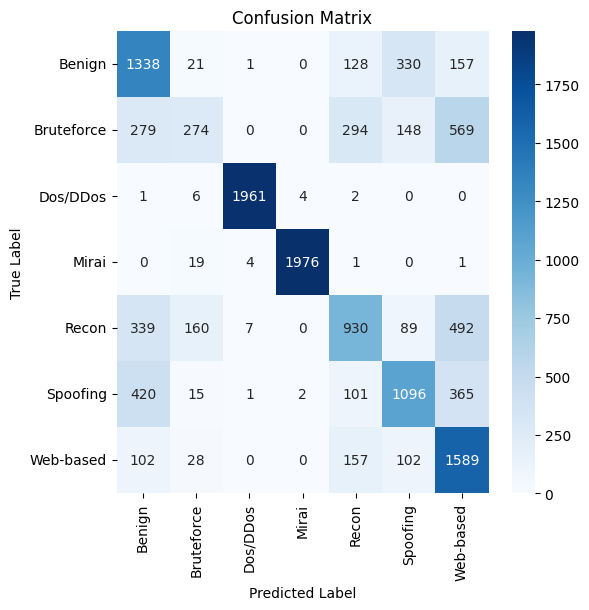

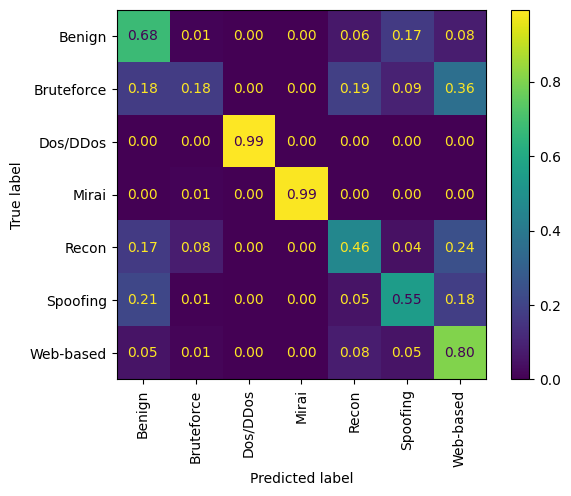

In [19]:
SGDC_clf_Y_pred = SGDC_clf.predict(X_test)
print(classification_report(Y_test, SGDC_clf_Y_pred))
plot_confusion_matrix(Y_test,SGDC_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, SGDC_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 5. MLP

In [25]:
# Create MLPClasifier
mlp = MLPClassifier(
  max_iter=10000,
  random_state=42
)

# Grid search for MLPClassifier
parameters = {
  'hidden_layer_sizes': [(50,), (100,), (128,), (256,)],
  'activation': ['relu'],
  'alpha': [0.0001, 0.001],
  'solver': ['adam'],
  'learning_rate': ['constant'],
  'learning_rate_init': [0.001, 0.0002, 0.0001]
}

mlp_grid = GridSearchCV(
  mlp,
  parameters,
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1, # Use all cores
)

mlp_grid.fit(X_train_scaled, Y_train)

# Extract best params
print(f"Best params: {mlp_grid.best_params_}")
print(f"Best score: {mlp_grid.best_score_}")

Best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate': 'constant', 'learning_rate_init': 0.0002, 'solver': 'adam'}
Best score: 0.7799944171433579


In [27]:
mlp = MLPClassifier(
  hidden_layer_sizes=(128,),
  activation='relu',
  alpha=0.0001,
  solver='adam',
  learning_rate='constant',
  learning_rate_init=0.0002,
  max_iter=10000,
  random_state=42
)
mlp.fit(X_train_scaled, Y_train)

MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.0002,
              max_iter=10000, random_state=42)

              precision    recall  f1-score   support

      Benign       0.72      0.82      0.77      1975
  Bruteforce       0.62      0.57      0.59      1564
    Dos/DDos       1.00      1.00      1.00      1974
       Mirai       1.00      0.99      1.00      2001
       Recon       0.78      0.58      0.67      2017
    Spoofing       0.82      0.66      0.73      2000
   Web-based       0.61      0.83      0.70      1978

    accuracy                           0.79     13509
   macro avg       0.79      0.78      0.78     13509
weighted avg       0.80      0.79      0.79     13509



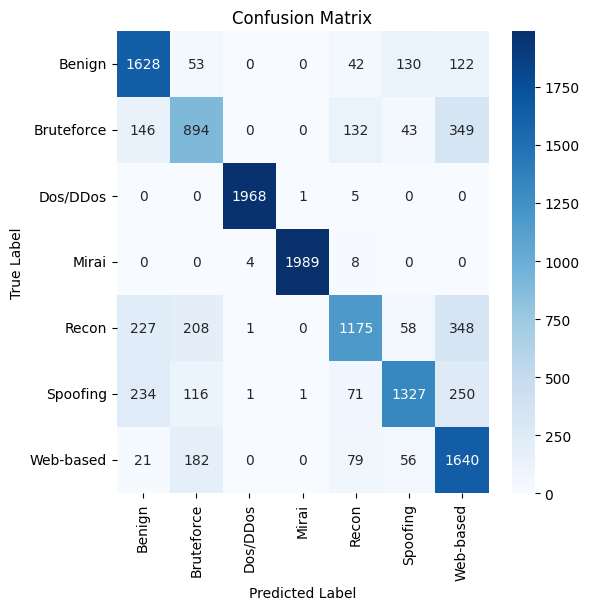

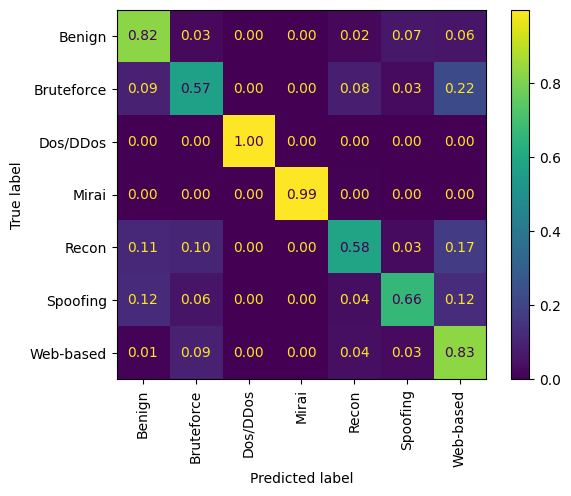

In [29]:
MLP_clf_Y_pred = mlp.predict(X_test_scaled)
print(classification_report(Y_test, MLP_clf_Y_pred))
plot_confusion_matrix(Y_test,MLP_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, MLP_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 6. Feature selection

In [46]:
# Get feature importances
importances = RF_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to display importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

            Feature  Importance
32              IAT    0.137822
1     Header_Length    0.064573
15        rst_count    0.060328
31         Tot size    0.057734
34         Magnitue    0.056359
29              AVG    0.053379
0     flow_duration    0.052754
28              Max    0.048668
2     Protocol Type    0.043496
27              Min    0.042720
14        urg_count    0.040905
37         Variance    0.036913
26          Tot sum    0.033209
4              Rate    0.031319
5             Srate    0.030929
3          Duration    0.024192
12        syn_count    0.023307
30              Std    0.022581
36       Covariance    0.022066
35           Radius    0.021551
13        fin_count    0.013644
33           Number    0.013550
38           Weight    0.013447
19              SSH    0.009600
17            HTTPS    0.008693
11        ack_count    0.008163
20              TCP    0.007884
10  ack_flag_number    0.005376
16             HTTP    0.004902
21              UDP    0.003609
9   psh_

In [47]:
# Cumulative importance threshold
cumulative_importance = importance_df['Importance'].cumsum()
threshold = 0.95  # Retain 95% of the importance

selected_features = importance_df[cumulative_importance <= threshold]['Feature'].tolist()
print(selected_features)
X_train_distilled = X_train[selected_features]
X_test_distilled = X_test[selected_features]

['IAT', 'Header_Length', 'rst_count', 'Tot size', 'Magnitue', 'AVG', 'flow_duration', 'Max', 'Protocol Type', 'Min', 'urg_count', 'Variance', 'Tot sum', 'Rate', 'Srate', 'Duration', 'syn_count', 'Std', 'Covariance', 'Radius', 'fin_count', 'Number', 'Weight']


In [48]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_distilled)
X_test_scaled = scaler.transform(X_test_distilled)

In [49]:
model_distilled = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
model_distilled.fit(X_train_scaled, Y_train)

# Evaluate performance
accuracy = model_distilled.score(X_test_scaled, Y_test)

              precision    recall  f1-score   support

      Benign       0.85      0.91      0.88      1997
  Bruteforce       0.80      0.81      0.81      1506
    Dos/DDos       1.00      1.00      1.00      1953
       Mirai       1.00      0.99      1.00      2015
       Recon       0.89      0.77      0.83      2033
    Spoofing       0.91      0.81      0.86      1938
   Web-based       0.79      0.92      0.85      2067

    accuracy                           0.89     13509
   macro avg       0.89      0.89      0.89     13509
weighted avg       0.89      0.89      0.89     13509



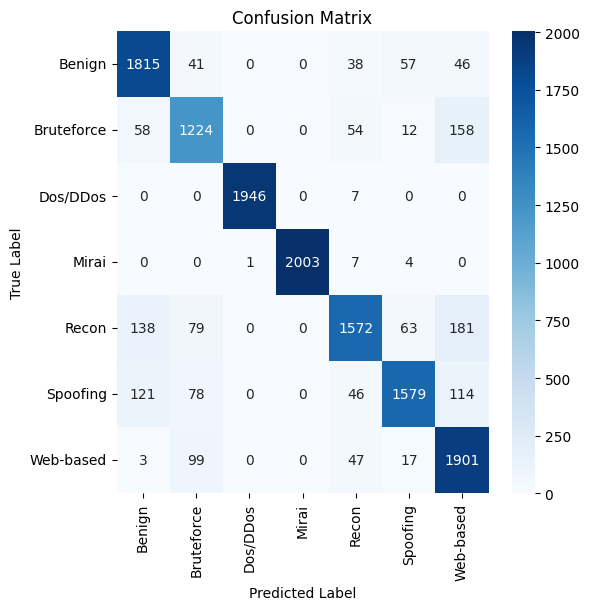

1

In [50]:
RF_clf_Y_pred = model_distilled.predict(X_test_scaled)
print(classification_report(Y_test, RF_clf_Y_pred))
plot_confusion_matrix(Y_test,RF_clf_Y_pred)